## Simple strategy - Moving Average Crossovers

The **"Moving Average Crossovers"** strategy for algorithmic trading is just like the ***"Hello world"*** program for coding beginners. It serves as a good starting point to learn coding for technical analysis.

<hr size="5"/>

### Table of Contents

* [1. Implement the strategy](#1.-Implement-the-strategy)
* [2. Plot figure](#2-Plot-figure)
* [3. Backtesting](#3-Backtesting)
* [4. Evaluate strategy](#4-Evalaute-strategy)

 **Requirements:**
 * pandas
 * numpy
 * matplotlib

### 1. Implement the strategy

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load aapl csv file
aapl = pd.read_csv('../../database/microeconomic_data/nasdaq_ticks_day/nasdaq_AAPL.csv', header=0, index_col='Date', parse_dates=True)

# We select only the data from 2015-2019
aapl = aapl.loc[pd.Timestamp('2015-01-01'):pd.Timestamp('2019-12-31')]

In [10]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
signals.tail()

,signal,short_mavg,long_mavg,positions
Date,,,,
2019-12-24,1.0,264.221056,235.930897,0.0
2019-12-26,1.0,265.398771,236.904727,0.0
2019-12-27,1.0,266.574494,237.841293,0.0
2019-12-30,1.0,267.656605,238.774814,0.0
2019-12-31,1.0,268.616614,239.686144,0.0


### 2. Plot figure

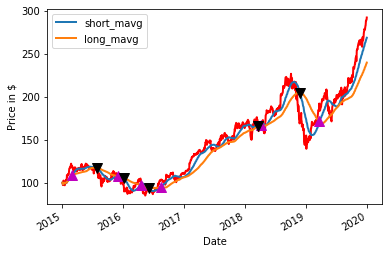

In [5]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

positions = (signals.positions).to_numpy()
short_mavg = (signals.short_mavg).to_numpy()
long_mavg = (signals.long_mavg).to_numpy()

# Plot the buy signals
ax1.plot(signals.loc[positions == 1.0].index, 
         short_mavg[positions == 1.0],
         '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals.loc[positions == -1.0].index, 
         long_mavg[positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

### 3. Backtesting

In [6]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the last lines of `portfolio`
portfolio.tail()

,AAPL,holdings,cash,total,returns
Date,,,,,
2019-12-24,28283.129883,28283.129883,84374.246979,112657.376862,0.000238
2019-12-26,28844.277954,28844.277954,84374.246979,113218.524933,0.004981
2019-12-27,28833.331299,28833.331299,84374.246979,113207.578278,-0.000097
2019-12-30,29004.461670,29004.461670,84374.246979,113378.708649,0.001512
2019-12-31,29216.381836,29216.381836,84374.246979,113590.628815,0.001869


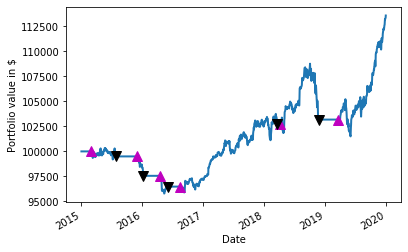

In [40]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

positions = signals.positions.to_numpy()

ax1.plot(portfolio.loc[positions == 1.0].index, 
         portfolio.total[positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[positions == -1.0].index, 
         portfolio.total[positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

### 4. Evaluate strategy

#### 4.1 Sharpe ratio

In [41]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.8311190106415088


#### 4.2 Maximum drawdown

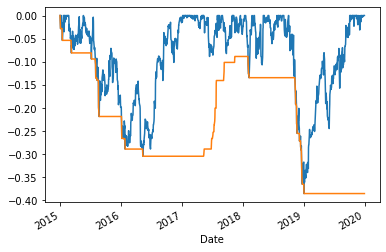

In [42]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = aapl['Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

#### 3. Compound Annual Growth Rate (CAGR)

In [43]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Close'][-1]) / aapl['Close'][1])) ** (365.0/days)) - 1

# Print the CAGR
print(cagr)

0.24654176746201206


### References:
* [DataCamp - Python for Finance: Algorithmic Trading](https://www.datacamp.com/community/tutorials/finance-python-trading?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406585355&utm_loc_interest_ms=&utm_loc_physical_ms=1009279&gclid=Cj0KCQjwrIf3BRD1ARIsAMuugNu2UkliuXEzSS4V08jCIQPtBByx7Eu8tEZh0J34NJ395kpOC_t0-MUaAtF5EALw_wcB)